**[Pipeline Implementation]**

1. VLM Tool
2. Agentic object detection pipeline
3. Running the object detector
4. Why Numbered Batching for Inferencing
5. Critiquing and Refining the Query
6. Validation Bounding Box predictions utilizing the VLM

### 1. VLM Tool



* Input
    * Image(path/ base64)
    * User request
* Output
    * Object: [str]

In [ ]:
import base64
import json
import base64, os, hashlib
import torch

from openai import OpenAI
from io import BytesIO
from PIL import Image
from dotenv import load_dotenv

In [39]:
# util function
# 프로젝트 루트 탐색
def find_project_root(marker_filename=".project-root"):
    current_dir = os.path.abspath(os.getcwd())
    while True:
        if os.path.isfile(os.path.join(current_dir, marker_filename)):
            return current_dir
        parent_dir = os.path.dirname(current_dir)
        if parent_dir == current_dir:
            raise FileNotFoundError(f"Could not find {marker_filename} in any parent directory.")
        current_dir = parent_dir

In [40]:
def encode_image(image_path):
    try:
        with open(image_path, "rb") as image_file:
            return base64.b64encode(image_file.read()).decode("utf-8")
    except Exception as e:
        print(f"Error encoding image: {e}")
        return None

In [52]:
class VLMTool:
    def __init__(self, api_key):
        self.client = OpenAI(api_key=api_key)

    def chat_completion(
        self,
        messages,
        model="o1",
        max_tokens=300,
        temperature=0.1,
        response_format=None
    ):
        """Calls GPT for chat completion.
        return first message of GPTs"""
        try:
            if model in ["gpt-4o", "gpt-4o-mini"]:
                response = self.client.chat.completions.create(
                    model=model,
                    messages=messages,
                    max_tokens=max_tokens,
                    temperature=temperature,
                    response_format=response_format if response_format else {"type": "text"}
                )
            elif model in ["o1"]:
                response = self.client.chat.completions.create(
                    model=model,
                    messages=messages,
                    response_format=response_format if response_format else {"type": "text"}
                )
            else:
                raise NotImplementedError("This model is not supported")

            return response.choices[0].message.content

        except Exception as e:
            print(f"Error calling LLM: {e}")
            return None

    def extract_objects_from_request(self, image_path, user_text, model="gpt-4o"):
        """ Asks the LLM to parse user request for which objects to detect/segment.
        Returns a list of objects in plain text."""
        base64_image = encode_image(image_path) # image encoding 방식 변경 가능
        if not base64_image:
            return None

        prompt = (
            "You are an AI vision assistant that extracts objects to be identified from a user's request."
            "If the user wants to detect or semantically segment all objects in the image, return a comma-separated list of objects you can see. "
            "If the user wants to detect or semantically segment specific objects, extract only those mentioned explicitly in their request. "
            "Respond ONLY with the list of objects, separated by commas, and NOTHING ELSE."
            "The objective here is only to understand the objects of interest that can be extracted from the image and the user's request."
            "You are not actually required to perform or execute the user's request."    
            )

        messages = [
            {"role": "system", "content": prompt},
            {
                "role": "user",
                "content": [
                    {"type": "text", "text": user_text},
                    {
                        "type": "image_url",
                        "image_url": {
                            "url": f"data:image/jpeg;base64,{base64_image}",
                            "detail": "high"
                        }
                    }
                ]
            }
        ]

        result = self.chat_completion(messages, model=model)
        if result:
            detected_objects = [
                obj.strip().lower()
                for obj in result.split(",")
                if obj.strip()
            ]
            return detected_objects

        return []

In [ ]:
"""
# chat_completion() 출력 예시 
import os
from dotenv import load_dotenv

project_root = find_project_root()
dotenv_path = os.path.join(project_root, ".env")
load_dotenv(dotenv_path) # .env 파일의 환경 변수를 os.environ에 로드 / 환경변수 전부 로드

api_key = os.getenv("OPENAI_API_KEY")
client = VLMTool(api_key=api_key)
chat_messages = [
    {"role": "system", "content": "You are a creative poet."},
    {"role": "user", "content": "Write a short poem about a lonely star."}
]

response = client.chat_completion(
    messages=chat_messages,
    model="gpt-4o",
    max_tokens=150,
    temperature=0.8
)
print(response)
"""

In [53]:
# extract_objects_from_request() 출력 예시
import os
from dotenv import load_dotenv

project_root = find_project_root()
dotenv_path = os.path.join(project_root, ".env")
load_dotenv(dotenv_path)

api_key = os.getenv("OPENAI_API_KEY")
client = VLMTool(api_key=api_key)


image_path = r"C:\Users\KIST\agentic-object-detection\data\image1.jpg"

# Test1: 모든 객체 탐지
user_request_1 = "Find all objects in this picture."
objects_1 = client.extract_objects_from_request(image_path, user_request_1)
print(f"요청: {user_request_1}")
print(f"결과: {objects_1}")
print()


요청: Find all objects in this picture.
결과: ['tomatoes', 'leaves', 'stems', 'soil', 'pathway', 'support structure.']



### 2. Agentic object detection pipeline

* Input
    * Image
    * Object labels
* Output
    * detection: [{bbox, score, label}]

=> for initial, final verification 

In [54]:
import torch
from transformers import AutoProcessor, AutoModelForZeroShotObjectDetection
from PIL import Image
import json

"""
from config import MODEL_TYPES, CONFIDENCE_THRESHOLD, INV_MODEL_TYPES
from utils.image_utils import draw_arrows_and_numbers, encode_image, draw_bounding_boxes
"""

class ObjectDetectionTool:
    """ 2. Agentic object detection pipeline"""
    """
    Performs object detection using GroundingDINO or OWL-ViT,
    plus an optional 'critique' (refinement) step with a VLM
    to yield a refined set of objects to detect.
    """
    def __init__(self, model_id, device, vlm_tool, confidence_threshold=0.2, concept_detection_model="gpt-4o", initial_critique_model="o1", final_critique_model="gpt-4o"):
        self.model_id = model_id
        self.processor = AutoProcessor.from_pretrained(model_id)
        self.model = AutoModelForZeroShotObjectDetection.from_pretrained(model_id).to(device)
        self.device = device
        self.vlm_tool = vlm_tool  # The LLMTool that can handle vision (GPT-4V) or similar
        self.confidence_threshold = confidence_threshold
        self.concept_detection_model = concept_detection_model
        self.initial_critique_model = initial_critique_model
        self.final_critique_model = final_critique_model
        
        # We store bounding boxes for potential usage later (e.g., for SAM).
        self.last_detection_bboxes = []
        self.last_filtered_objects = []
    


### 3. Running the Object Detector

* Input
    * Image
    * initial_detection
* Output
    * annotated_image

In [ ]:
""" Configuration """
# Model configuration
MODEL_TYPES = {
    "owlvit": "google/owlvit-base-patch32",
    "grounding_dino": "IDEA-Research/grounding-dino-tiny",
}

INV_MODEL_TYPES = {v:k for k,v in MODEL_TYPES.items()}

DEFAULT_MODEL_TYPE = "grounding_dino"
MODEL_ID = MODEL_TYPES[DEFAULT_MODEL_TYPE]

# Device configuration
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

# Visualization
COLOR_PALETTE = [
    "red", "blue", "green", "purple", "orange", 
    "cyan", "magenta", "yellow", "brown", "pink"
]

# Threshold
CONFIDENCE_THRESHOLD = 0.2

In [72]:
import cv2
import base64
import os
import numpy as np
from PIL import Image, ImageDraw, ImageFont

def draw_arrows_and_numbers(image_path, detected_objects):
    """
    Draws arrows and numbers on an image to label detected objects.
    """
    img = cv2.imread(image_path, cv2.IMREAD_UNCHANGED)
    font = cv2.FONT_HERSHEY_SIMPLEX
    used_positions = []

    # Pad the image with a white border
    top, bottom, left, right = 50, 50, 50, 50
    img = cv2.copyMakeBorder(img, top, bottom, left, right, cv2.BORDER_CONSTANT, value=[255, 255, 255])

    height, width, _ = img.shape

    for i, (num, obj, box) in enumerate(detected_objects):
        x1, y1, x2, y2 = map(int, box)
        cx, cy = (x1 + x2) // 2, (y1 + y2) // 2  # Center of the bounding box

        # Adjust coordinates for padded image
        x1 += left
        y1 += top
        x2 += left
        y2 += top
        cx += left
        cy += top

        # Determine arrow direction towards the nearest border
        distances = {'top': cy, 'bottom': height - cy, 'left': cx, 'right': width - cx}
        direction = min(distances, key=distances.get)

        if direction == 'top':
            arrow_end = (cx, top)
            text_position = (cx - 10, top - 10)
        elif direction == 'bottom':
            arrow_end = (cx, height - bottom)
            text_position = (cx - 10, height - 5)
        elif direction == 'left':
            arrow_end = (left, cy)
            text_position = (left - 30, cy + 5)
        else:
            arrow_end = (width - right, cy)
            text_position = (width - 30, cy + 5)

        # Draw the dashed arrow from the object center to the border
        color = (0, 0, 0)  # Black color for all arrows
        line_type = cv2.LINE_4
        cv2.arrowedLine(img, (cx, cy), arrow_end, color, 2, tipLength=0.3)

        # Draw a semi-transparent rectangle behind the text
        overlay = img.copy()
        cv2.rectangle(overlay, (text_position[0] - 5, text_position[1] - 20), (text_position[0] + 30, text_position[1] + 5), (0, 0, 0), -1)
        alpha = 0.5
        cv2.addWeighted(overlay, alpha, img, 1 - alpha, 0, img)

        # Draw the number at the border with black text
        cv2.putText(img, str(num), text_position, font, 0.5, color, 2)

    labeled_image_path = "labeled_objects_image0.jpg"
    cv2.imwrite(labeled_image_path, img)
    return labeled_image_path

In [57]:
def _run_detector(self, image_path, query_list):
    """
    Low-level routine to run the detection model on `query_list`.
    Returns: (detected_objects_final, labeled_image_path)
    Where `detected_objects_final` = [(num, label, [x1,y1,x2,y2]), ...].
    """
    from PIL import ImageFont
    
    # Format queries for the model
    if INV_MODEL_TYPES[self.model_id] == "owlvit":
        formatted_queries = [f"An image of {q}" for q in query_list]
    elif INV_MODEL_TYPES[self.model_id] == "grounding_dino":
        formatted_queries = " ".join([f"{q}." for q in list(set(query_list))])
    else:
        raise NotImplementedError("Model not supported")

    # Load image
    img = Image.open(image_path).convert("RGB")
    inputs = self.processor(
        text=formatted_queries, 
        images=img, 
        return_tensors="pt", 
        padding=True, 
        truncation=True
    ).to(self.device)

    # PyTorch gradient 계산 비활성화
    self.model.eval()
    with torch.no_grad():
        outputs = self.model(**inputs)
    
    # Post-process bounding boxes
    if INV_MODEL_TYPES[self.model_id] == "grounding_dino":
        results = self.processor.post_process_grounded_object_detection(
            outputs, 
            inputs.input_ids,
            target_sizes=[img.size[::-1]]
        )
        boxes = results[0]["boxes"]
        scores = results[0]["scores"]
        labels = results[0]["labels"]
    elif INV_MODEL_TYPES[self.model_id] == "owlvit":
        logits = torch.max(outputs["logits"][0], dim=-1)
        scores = torch.sigmoid(logits.values).cpu().numpy()
        labels = logits.indices.cpu().numpy()
        boxes = outputs["pred_boxes"][0].cpu().numpy()
    else:
        raise NotImplementedError("Model not supported")            

    detected_objects_final = []
    idx = 1
    for score, box, label_idx in zip(scores, boxes, labels):
        if score < self.confidence_threshold:
            continue
        detected_objects_final.append((idx, label_idx, box.tolist()))
        idx += 1

    # Draw numbers
    labeled_image_path = draw_arrows_and_numbers(image_path, detected_objects_final)
    return detected_objects_final, labeled_image_path

# 클래스에 메서드 추가
ObjectDetectionTool._run_detector = _run_detector

#### Exercise: detection + visualization 

In [ ]:
# 환경 설정
project_root = find_project_root()
dotenv_path = os.path.join(project_root, ".env")
load_dotenv(dotenv_path)
api_key = os.getenv("OPENAI_API_KEY")

# VLMTool 초기화
vlm_tool = VLMTool(api_key=api_key)

# ObjectDetectionTool 초기화
detector = ObjectDetectionTool(
    model_id=MODEL_ID,  # "IDEA-Research/grounding-dino-tiny"
    device=DEVICE,      # "cuda" or "cpu"
    vlm_tool=vlm_tool,
    confidence_threshold=CONFIDENCE_THRESHOLD,  # 0.2
    concept_detection_model="gpt-4o",
    initial_critique_model="o1",
    final_critique_model="gpt-4o"
)

print(f"  - Model: {MODEL_ID}")
print(f"  - Device: {DEVICE}")
print(f"  - Confidence threshold: {CONFIDENCE_THRESHOLD}")

  - Model: IDEA-Research/grounding-dino-tiny
  - Device: cuda
  - Confidence threshold: 0.2


In [ ]:
# === Object Detection ===
image_path = r"C:\Users\KIST\agentic-object-detection\data\image1.jpg"

# 사용자 요청에서 객체 추출 (VLM 사용)
user_request = "Detect all objects in this image"
objects_to_detect = vlm_tool.extract_objects_from_request(image_path, user_request)
print(f" List of Object: {objects_to_detect}")
print()

# detection
detected_objects, labeled_image_path = detector._run_detector(image_path, objects_to_detect)
print(f"🎯 Number of detected object: {len(detected_objects)}")
print(f"📁 Labeled image: {labeled_image_path}")
print()

# reult
print("상세 결과:")
for num, label_idx, bbox in detected_objects:
    x1, y1, x2, y2 = bbox
    print(f"  [{num}] 레이블: {label_idx}, 위치: ({x1:.1f}, {y1:.1f}, {x2:.1f}, {y2:.1f})")

 List of Object: ['tomatoes', 'leaves', 'vines', 'soil', 'pathway', 'support structure.']

🎯 Number of detected object: 20
📁 Labeled image: labeled_objects_image0.jpg

상세 결과:
  [1] 레이블: tomatoes, 위치: (103.6, 215.3, 157.1, 270.2)
  [2] 레이블: tomatoes, 위치: (55.0, 244.3, 111.2, 295.2)
  [3] 레이블: tomatoes, 위치: (153.7, 82.8, 196.8, 124.2)
  [4] 레이블: tomatoes, 위치: (111.6, 74.0, 165.4, 116.4)
  [5] 레이블: tomatoes, 위치: (185.2, 195.1, 220.2, 222.0)
  [6] 레이블: tomatoes, 위치: (143.9, 182.1, 186.1, 221.1)
  [7] 레이블: vines, 위치: (1.0, 0.9, 278.2, 339.8)
  [8] 레이블: pathway, 위치: (257.7, 112.5, 437.7, 340.1)
  [9] 레이블: tomatoes, 위치: (78.7, 7.6, 112.0, 39.1)
  [10] 레이블: tomatoes, 위치: (93.0, 323.4, 119.9, 340.5)
  [11] 레이블: tomatoes, 위치: (52.2, 3.1, 81.1, 31.1)
  [12] 레이블: vines, 위치: (273.6, 1.2, 511.3, 339.9)
  [13] 레이블: leaves, 위치: (41.7, 143.7, 98.4, 221.5)
  [14] 레이블: leaves, 위치: (171.3, 291.4, 221.1, 340.1)
  [15] 레이블: leaves, 위치: (23.4, 62.1, 72.0, 111.6)
  [16] 레이블: leaves, 위치: (111.1, 276.8, 155.1, 

c:\Users\KIST\agentic-object-detection\.venv\Lib\site-packages\transformers\models\grounding_dino\processing_grounding_dino.py:93: FutureWarning: The key `labels` is will return integer ids in `GroundingDinoProcessor.post_process_grounded_object_detection` output since v4.51.0. Use `text_labels` instead to retrieve string object names.
  warnings.warn(self.message, FutureWarning)


원본 이미지:


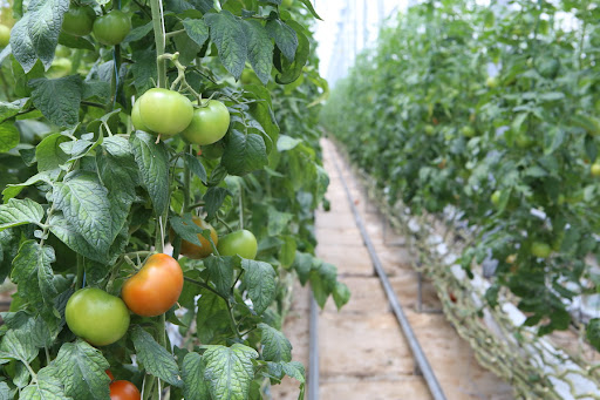


탐지 결과 이미지:


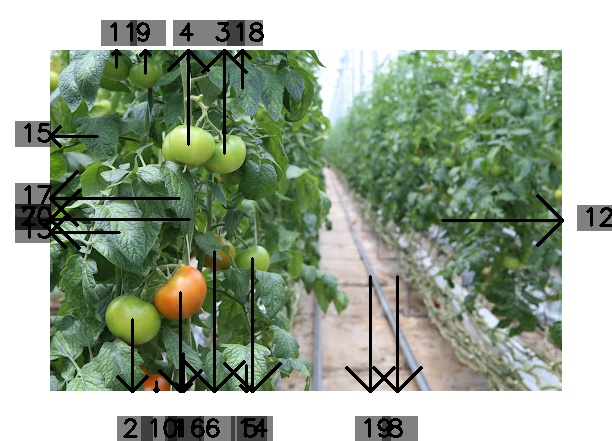

In [ ]:
# === 결과 이미지 표시 ===

from PIL import Image
from IPython.display import display

# 원본 이미지
print("원본 이미지:")
original_img = Image.open(image_path)
display(original_img.resize((600, 400)))

# 탐지 결과 이미지
print("\n탐지 결과 이미지:")
labeled_img = Image.open(labeled_image_path)
display(labeled_img)

📋 특정 객체 탐지: ['tomatoes']
🎯 탐지된 객체 수: 13
📁 레이블 이미지: labeled_objects_image0.jpg


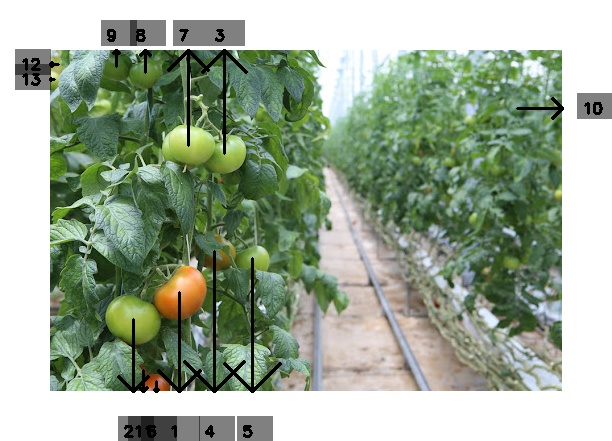

In [73]:
# === 6. 특정 객체만 탐지하는 예제 ===

# 특정 객체만 탐지
user_request_specific = "Find tomatoes in this picture"
specific_objects = vlm_tool.extract_objects_from_request(image_path, user_request_specific)

print(f"📋 특정 객체 탐지: {specific_objects}")

detected_specific, labeled_specific_path = detector._run_detector(image_path, specific_objects)

print(f"🎯 탐지된 객체 수: {len(detected_specific)}")
print(f"📁 레이블 이미지: {labeled_specific_path}")

# 결과 표시
labeled_specific_img = Image.open(labeled_specific_path)
display(labeled_specific_img)

### 4. Why Numbered Batching for Inferencing

### 5. Critiquing and Refining the Query

### 6. Validation Bounding Box predictions utilizing the VLM